In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-05-16 19:54:18.855317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 19:54:19.309590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 19:54:19.312707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 19:54:19.322852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

True

r/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 19:54:19.331698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 19:54:20.268372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 19:54:20.271553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-16 19:54:20.281509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysF

In [7]:
!nvidia-smi

Tue May 16 20:19:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:00:0D.0 Off |                    0 |
| N/A   41C    P0    69W / 300W |   8977MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:00:0E.0 Off |                    0 |
| N/A   

In [4]:
print(1+3)

4


In [5]:
!gdown

/bin/bash: gdown: command not found


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import math
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
import os 
import glob
import shutil
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

In [12]:
DIR = "../xray/CLAHE_dataset_2_altern/DATASET"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 21239 files belonging to 5 classes.
Using 19116 files for training.
Found 21239 files belonging to 5 classes.
Using 2123 files for validation.
['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


In [13]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

In [14]:
resnet50_weights = '../xray/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = ResNet50(input_shape= (256,256,3), weights = resnet50_weights, include_top=False)
#     base_model.trainable=False #freezing the layer

x=base_model.output
x = tf.keras.layers.GlobalMaxPooling2D() (x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
out=tf.keras.layers.Dense(5,activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=out)
    # model.summary()
print("----Training the network----")
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
     
early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 10 ,
                               restore_best_weights=True)
    #model_checkpoint
mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
epochs = 40
#stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, 
                  validation_data = test_dataset, 
                  epochs = epochs, 
                  callbacks = [stepDecay,mc])

----Training the network----
Epoch 1/40
597/598 [============================>.] - ETA: 0s - loss: 0.6783 - accuracy: 0.7362
Epoch 1: val_loss improved from inf to 0.98163, saving model to resnet_model.h5
598/598 [==============================] - 65s 89ms/step - loss: 0.6784 - accuracy: 0.7362 - val_loss: 0.9816 - val_accuracy: 0.6434 - lr: 0.1000
Epoch 2/40
597/598 [============================>.] - ETA: 0s - loss: 0.4243 - accuracy: 0.8334
Epoch 2: val_loss improved from 0.98163 to 0.48100, saving model to resnet_model.h5
598/598 [==============================] - 54s 88ms/step - loss: 0.4242 - accuracy: 0.8335 - val_loss: 0.4810 - val_accuracy: 0.7942 - lr: 0.1000
Epoch 3/40
597/598 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8601
Epoch 3: val_loss did not improve from 0.48100
598/598 [==============================] - 53s 87ms/step - loss: 0.3638 - accuracy: 0.8602 - val_loss: 3.1197 - val_accuracy: 0.3391 - lr: 0.1000
Epoch 4/40
597/598 [==============

KeyboardInterrupt: 

In [6]:
model.save('model_2_resnet50_92_91_supersmooth')

INFO:tensorflow:Assets written to: model_2_resnet50_92_91_supersmooth/assets


INFO:tensorflow:Assets written to: model_2_resnet50_92_91_supersmooth/assets


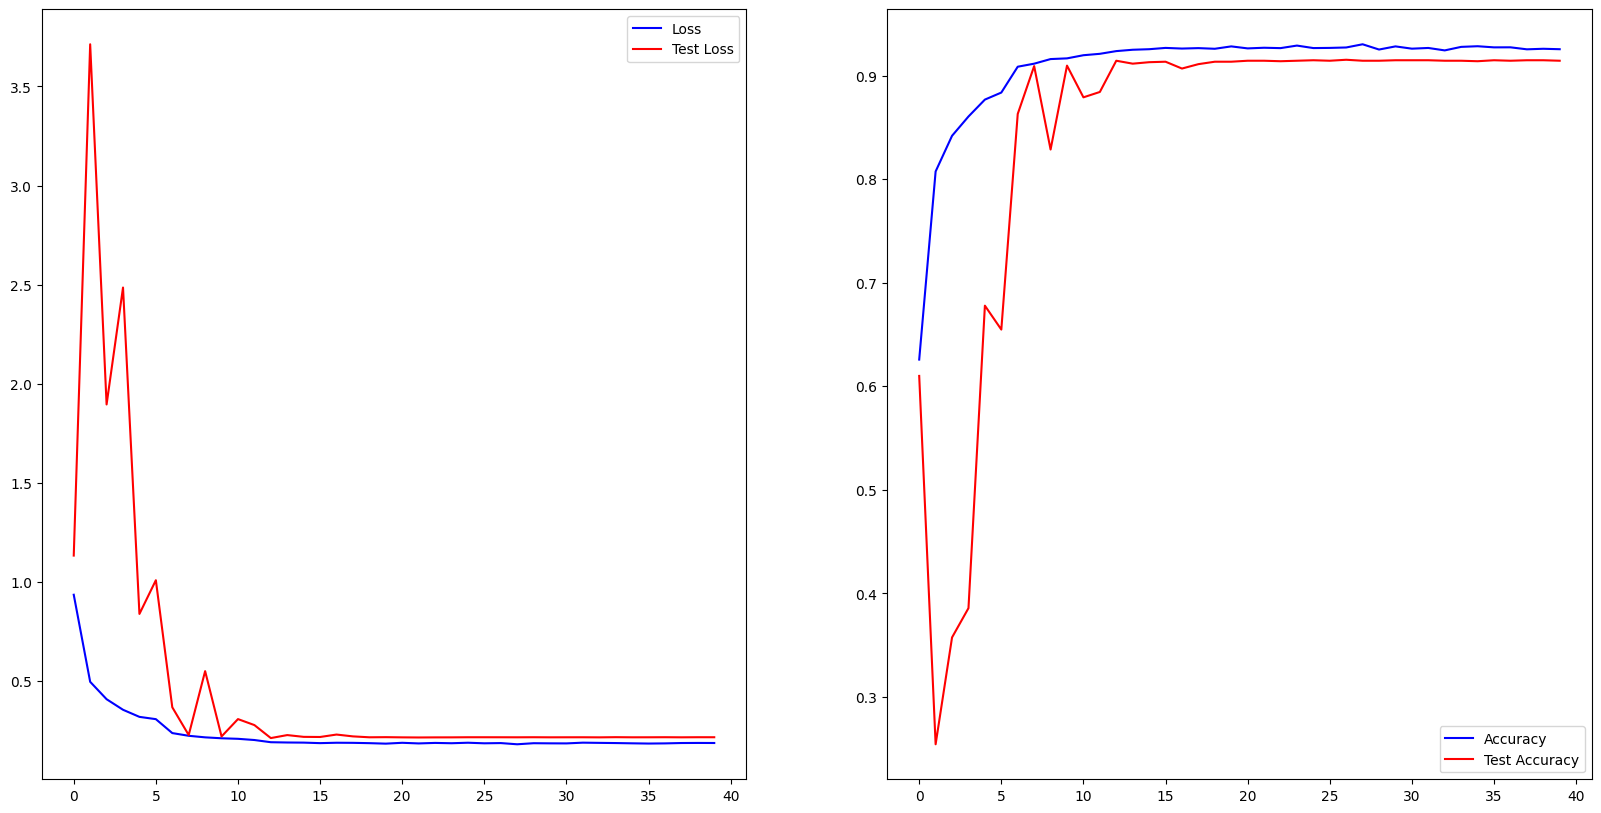

In [8]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

In [36]:
model.save('model2_resnet50_91_87.h5')

1/1 [==============================] - 0s 39ms/step























2023-05-16 22:48:18.351484: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 11 of dimension 0 out of bounds.
2023-05-16 22:48:18.352857: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 12 of dimension 0 out of bounds.
2023-05-16 22:48:18.353698: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 13 of dimension 0 out of bounds.
2023-05-16 22:48:18.354512: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 14 of dimension 0 out of bounds.
2023-05-16 22:48:18.355332: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 15 of dimension 0 out of bounds.
2023-05-16 22:48:18.356116: W tensorflow/core/framework/op_kernel.cc:1

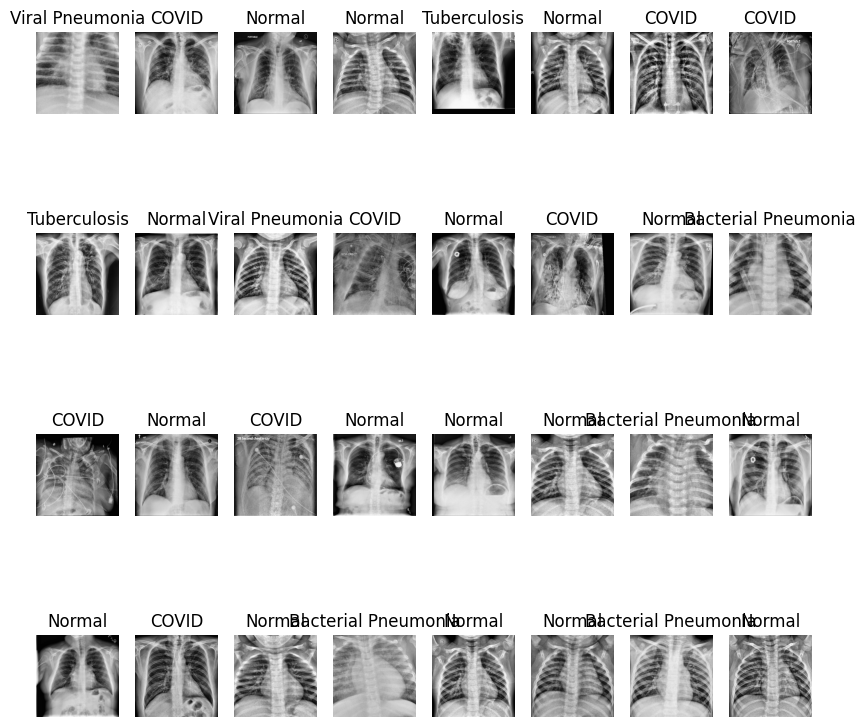

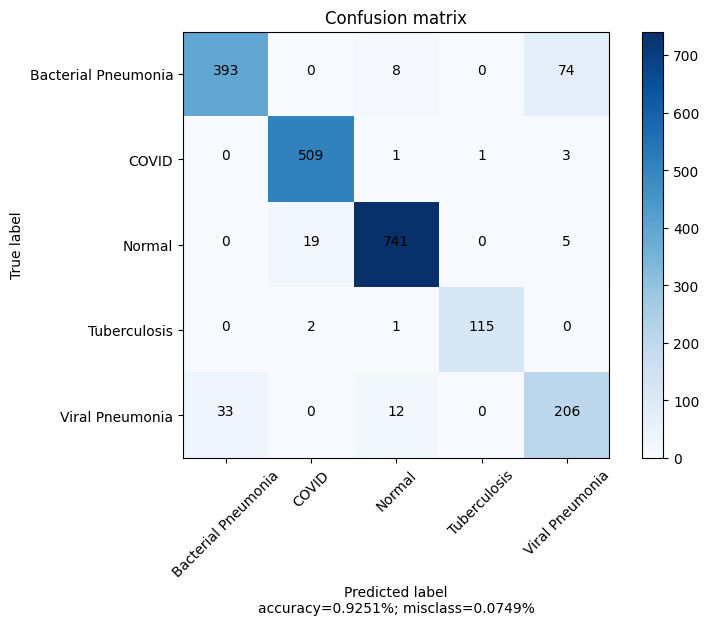

In [76]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
#model = load_model('/content/drive/MyDrive/resnet_model_2_(2)_96_92.h5')

def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    import matplotlib

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

for images, labels in test_dataset.take(100):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""path = "/content/covid-classification-ml/Covid19_Dataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:1500]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
      #print(fullPath)
    except:
      print("Error on image:", fullPath)"""

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)